# CNN Model (Notebook version)
## 1) Data Pre-processing
Import the libraries

In [1]:
import os
import cv2
import random
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda:0
GeForce GTX 1050 Ti


In [2]:
# Parameters:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
TABLE = NUMBER+ALPHABET # The table for the captcha
LEN_OF_TABLE=36
BATCH_SIZE=100
LEN_OF_CAPTCHA=6
LEARNING_RATE=0.001

Load the data, please modify the path by yourself

In [3]:
# Load the data from the Google Drive
# data_dir = Path("/content/drive/MyDrive/Data")

# path of data set for local
data_dir = Path("./dataset")

images = list(data_dir.glob("*.jpg")) #the size of dataset
print("Number of images found: ", len(images))


Number of images found:  10000


The CAPTCHA samples in the data set

Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


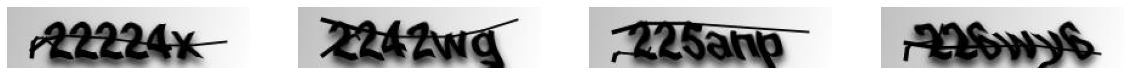

In [4]:
sample_images =images[:4] 
_,ax = plt.subplots(1,4, figsize=(20,6))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i%4].imshow(img)
    ax[i%4].axis('off')
plt.show()

### Customize the data set class

In [5]:
# Convert the captcha into the (6*36,) vector (6 characters,10 numbers + 26 Upper case characters)
# 1 means the captcha has this character in TABLE, 0 means not
def captcha_to_vector(captcha_str):
    captcha_str = captcha_str.upper()
    vector = np.zeros(36*6, dtype=np.float32)
    for i, char in enumerate(captcha_str):
        ascii = ord(char) # Convert char into ascii code
        if 48 <= ascii <= 57:# for numbers
            index = ascii-48
        elif 65 <= ascii <= 90:# for characters
            index = ascii-ord('A')+10
        vector[i*LEN_OF_TABLE+index] = 1.0
    return vector

In [6]:
# Convert the vector into the captcha (the input vector is different from the vector above)
# example: 
#   input:[1,2,34,2,6,7] 
#   output:"23Y378"
def vector_to_captcha(vector):
    captcha_str = ""
    for i in vector:
        captcha_str += TABLE[i]
    return captcha_str

In [7]:
# Custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None, target_transform=None, height=50, width=200):
        self.transform = transform
        self.target_transform = target_transform
        self.images = images
        self.width = width
        self.height = height

    def __getitem__(self, index):
        # get the image with path
        image = cv2.imread(str(self.images[index]))
        # convert the image into grayscale
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY) 
        # resize the image to ensure the size
        image = cv2.resize(image, (self.width, self.height))
        # Binarization of images
        _, image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)

        label = captcha_to_vector(self.images[index].name.split("_")[0])
        # Apply the transform to the image
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

Split and create data sets

In [8]:
random.shuffle(images)
# test data
test_data = images[8000:]  # last 2000 images in data set are for for test

# the part for training
training = images[:8000]
valid_data = training[6000:]  # last 2000 images in training set are for validation
train_data = training[:6000]  # 6000 images for train

print("test set size:", len(test_data))
print("validation set size:", len(valid_data))
print("train set size:", len(train_data))

train_set = CustomDataset(train_data, transform=transforms.ToTensor())
valid_set = CustomDataset(valid_data, transform=transforms.ToTensor())
test_set = CustomDataset(test_data, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)


test set size: 2000
validation set size: 2000
train set size: 6000


## Sample
After Improvement (Origin -> Grayscale -> Binarization)

![](./sample.jpg)

## 2) CNN Model

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=5, padding=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer5 = nn.Linear(64*3*12, 512)
        self.out = nn.Linear(512, 36*6)

    def forward(self, x):
        x = self.layer1(x)  # Input: torch.Size([100, 1, 50, 200])
        x = self.layer2(x)  # Input: torch.Size([100, 32, 25, 100])
        x = self.layer3(x)  # Input: torch.Size([100, 48, 12, 50])
        x = self.layer4(x)  # Input: torch.Size([100, 64, 6, 25])

        # Output: torch.Size([100, 64, 3, 12])
        x = x.view(-1, 64*3*12)
        x = self.layer5(x)
        output = self.out(x)
        # Output: torch.Size([100, 36*6])
        return output

In [10]:
# Initialize the model 
model = CNN().to(device)

In [11]:
def valid(model, valid_dataloader, device):
    num_correct = 0  # the counter for the correct items
    num_total = len(valid_dataloader)*BATCH_SIZE  # the counter for the total items
    model.eval()  # set the evaluation state of the model
    with torch.no_grad():
        for _, (images, labels) in enumerate(valid_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            labels = labels.reshape((BATCH_SIZE, LEN_OF_CAPTCHA, LEN_OF_TABLE))
            output = output.reshape((BATCH_SIZE, LEN_OF_CAPTCHA, LEN_OF_TABLE))
            labels = torch.argmax(labels, dim=2) # get the captcha character index
            output = torch.argmax(output, dim=2) # get the predict character index
            num_correct += ((output == labels).sum(dim=1) == LEN_OF_CAPTCHA).sum().item()
        return num_correct / num_total * 100


def test(model, test_dataloader, device):
    num_correct = 0  # the counter for the correct items
    num_total = len(test_dataloader)*BATCH_SIZE  # the counter for the total items
    model.eval()  # set the evaluation state of the model

    with torch.no_grad():
        for _, (images, labels) in enumerate(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            labels = labels.reshape((BATCH_SIZE, LEN_OF_CAPTCHA, LEN_OF_TABLE))
            output = output.reshape((BATCH_SIZE, LEN_OF_CAPTCHA, LEN_OF_TABLE))
            labels = torch.argmax(labels, dim=2) # get the captcha character index
            output = torch.argmax(output, dim=2) # get the predict character index
            num_correct += ((output == labels).sum(dim=1) == LEN_OF_CAPTCHA).sum().item()
        accuracy = num_correct / num_total * 100
        return accuracy

In [12]:
def train(model, train_dataloader, valid_dataloader, device):
    model.train()
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(15):
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            predict = model(images)
            optimizer.zero_grad()
            loss = criterion(predict, labels)
            loss.backward()
            optimizer.step()
        accuracy = valid(model, valid_dataloader, device)
        print("epoch: {} loss: {:.10f} accuracy: {:.4f}".format((epoch+1), loss.item(), accuracy))

In [13]:
print("\nTraining")
train(model, train_dataloader, valid_dataloader, device)

print("\nTesting")
accuracy = test(model, test_dataloader, device)
print("Accuracy: {}".format(accuracy))


Training
epoch: 1 loss: 0.1040290073 accuracy: 0.0000
epoch: 2 loss: 0.0761534423 accuracy: 0.0500
epoch: 3 loss: 0.0496696271 accuracy: 11.1500
epoch: 4 loss: 0.0220106412 accuracy: 60.1500
epoch: 5 loss: 0.0080637904 accuracy: 86.8000
epoch: 6 loss: 0.0052945684 accuracy: 92.0500
epoch: 7 loss: 0.0025808441 accuracy: 94.2500
epoch: 8 loss: 0.0017363328 accuracy: 95.3500
epoch: 9 loss: 0.0011386618 accuracy: 96.5500
epoch: 10 loss: 0.0007587419 accuracy: 96.6500
epoch: 11 loss: 0.0003841490 accuracy: 97.1500
epoch: 12 loss: 0.0002893746 accuracy: 97.1500
epoch: 13 loss: 0.0002455553 accuracy: 97.2000
epoch: 14 loss: 0.0001562227 accuracy: 97.5000
epoch: 15 loss: 0.0001285897 accuracy: 97.5500

Testing
Accuracy: 97.25
